# Residual risk of HIV transfusion transmission with NAT screening

*Eduard Grebe <EGrebe@vitalant.org>, 17 July 2020*

The code in this repository implements a tool for estimating the residual risk 
of HIV transfusion transmission despite screening of blood donation samples with 
nucleic acid testing (NAT). The central concepts underlying the approach is the 
"infectious window period" (IWP) and HIV incidence in the donor population -- 
reflecting the probability that a random donation will be in the infectious 
window period. The infectious window period is a function of the viral growth 
rate during early ramp-up viraemia, the sensitivity of the screening assay and 
the volume transfused. Multiplying the infectious window period by incidence 
yields the probability (per transfusion) of a transfusion transmission.

This "incidence times window period" model is well-established and is described 
in:

* Busch MP, Glynn SA, Stramer SL, Strong DM, Caglioti S, Wright DJ, Pappalardo B, Kleinman SH. A new strategy for estimating risks of transfusion-transmitted viral infections based on rates of detection of recently infected donors. Transfusion. 2005;45:254–264. doi:[10.1111/j.1537-2995.2004.04215.x](https://doi.org/10.1111/j.1537-2995.2004.04215.x).

Busch et al. presumed infectivity at a concentration of 1 RNA copy/20mL (i.e. 
the approximate volume of packed red blood cell components). They estimated the 
window period from presumed infectivity to individual donation NAT (ID-NAT) 
detection at 5.6 days, and from ID-NAT to minipool NAT (MP-NAT) with minipools 
of 16 samples at 3.4 days.

Their approach was an application of the general logic described Weusten and 
colleagues in in 2002:

* Weusten JJAM, Van Drimmelen HAJ, Lelie PN. Mathematic modeling of the risk of HBV, HCV, and HIV transmission by window-phase donations not detected by NAT. Transfusion. 2002;42:537–548.

The same first author led a refinement of this mathematic model published in 
2011, and on which this implementation draws heavily:

* Weusten JJAM, Vermeulen M, Van Drimmelen HAJ, Lelie PN. Refinement of a viral transmission risk model for blood donations in seroconversion window phase screened by nucleic acid testing in different pool sizes and repeat test algorithms. Transfusion. 2011;51:203-215. doi:[10.1111/j.1537-2995.2010.02804.x](https://doi.org/10.1111/j.1537-2995.2010.02804.x).

This software tool implementes the same basic logic as the Weusten et al. (2011) 
model, but diverges from it in the following important ways:

1. the probability of a transfusion transmission as a function of time since infection is modeled using a log-linear viral growth model (Fiebig et al., 2003) and an HIV-TT dose response model by Belov et al. (submitted), that was fit to data from a non-human primate SIV transmission study (Ma et al., 2009);
2. we are agnostic as to the source of HIV incidence estimates, which are treated as external to the model, rather than relying on repeat donor seroconversion patterns; and
3. we provide a method for conducting an uncertainty analysis by specifying distributions around critical model parameters and drawing sets of parameter combinations to produce credible ranges around infectious window period and residual risk estimates.

It also draws inspiration from a residual risk estimation tool previously 
developed and released by Alex Welte, Eduard Grebe and Andrew Powrie as part of 
an HIV infection dating tool:

* Grebe E, Facente SN, Powrie A, Gerber J, Grootboom K, Priede G, Welte A. Infection Dating Tool. Zenodo. 2018. doi:[10.5281/zenodo.1488117](https://doi.org/10.5281/zenodo.1488117).

This tool is a work and progress and contributions are encouraged. Enhancements 
currently contemplated include incorporating enhancements to the underlying 
model by Jeremy Bingham under the supervision of Alex Welte.

## Suggested citation

If you use this code in published research, we suggest citing both the Weusten 
article and this repository, by means of the DOI on Zenodo:

* Grebe, E. (2019) Residual risk of HIV transfusion transmission with NAT screening. Version 1.0. doi:[10.5281/zenodo.3588570](https://doi.org/10.5281/zenodo.3588570).

## Running

This Jupyter notebook requires Python 3 and:

* numpy
* scipy
* jupyterlab (to render the notebook; the classic Jupyter notebook server should also work)
* matplotlib (to render the plots in the example)

If you use conda, you can set up an environment called `residualrisk` by using the environment specification included with this repository and activate it by executing:

```
conda env create -f environment.yml
conda activate residualrisk
```

Or you can install the dependencies with pip.

## Notebook setup

In [1]:
import math
import multiprocessing as mp
import numpy as np
import scipy.stats as stats
import scipy.integrate as si
import matplotlib.pyplot as plt

## General approach to residual risk

For the purposes of this analysis, residual risk is defined as the probability of transmission to the recipient (per unit transfused). Since sources of risk outside of the early-infection window period (such as laboratory error or that a rare genetic variant of the infectious agent fails to react to all screening assays) are thought to be neglible, the probability that any random unit will be infectious is a function of
* the the probability per unit time that any given donor will acquire the infection; and
* the length of the infectious window period, i.e. the interval from when a donor (on average) becomes infectious and when (on average) a particular laboratory test becomes reactive.

Although in principle disease incidence is distinct from the per-unit time risk of infection that an uninfected at-risk persion would be exposed to, in practice when the incidence is small (such as HIV incidence in blood donors), it is essentially equivalent. So observed HIV incidence of 10 cases per 100,000 person-years in a donor population would equate to a 0.01% probability that any random HIV-uninfected donor becomes infected over a one year period. The risk that a random donor became infected within any given period, e.g. two weeks, prior to donation would be directly proportional to the risk per year, so that in our example the probability that any given donor became infected within the two weeks prior to donation would be $\frac{2}{52} \cdot 0.0001 = 0.00038\%$.

In this notebook, and the linked web-based residual risk estimation tool, it is assumed that the user has appropriately estimated incidence in the donor pool. In practice this would usually require relying either solely on data from repeat donors (where prior negative donations allow the direct observation of infection events and exposure time or time 'at risk') or the use of a method for estimating incidence in first-time donors (e.g. biomarkers of 'recent infection') and an appropriately weighted incidence estimate according to the proportion of donations collected from each group of donors. It may also be necessary to adjust incidence to account for the probability that an infectious unit would be interdicted based on the presence of other markers. For example if there are high rates of pre-existing HCV infection in donors who acquire HIV, the risk of HIV transmission would be over-estimated if incidence were not adjusted based appropriately (Kleinman et al., 1997).

It is important to account for the fact that material sourced from a newly-infected donor is not immediately infectious, since the infection first has to establish itself and a sufficient viral load be mounted to lead to infection in the recipient. This notebook therefore presents an approach for deriving the length of the 'infectious window period' (IWP) from data on transfusion transmission 'dose response' (i.e. the probability of transmission as a function of the transfused dose) and the sensitivity of the screening assay (i.e. the probability that an infection will fail to be detected as a function of the viral load). 

The residual risk of transfusion transmission is then simply the product of the infectious window period and incidence (in the same units of time):

$$RR = IWP \cdot \hat{I}$$

or (more accurately) the  IWP (in years) times the annual risk of infection. In our example, an IWP of 7 days would translate to a per-unit residual risk of transfusion transmission of $ \frac{7}{365.25} \cdot 0.0001 = 0.00019\%$ or 1 in 521,786 transfusions.

## Model for the infectious window period (IWP)

We largely rely on the model of Weusten et al. (2011) and the HIV-TT dose-response model of Belov et al. (2020) to derive the infectious window period (called "risk-day equivalents" by Weusten et al.). 

### Parameters

Key components of the model are:

1. The log-linear viral growth rate (or doubling time) during ramp-up viraemia
2. The probability that a certain concentration of virus in the transfused component leads to transmission
3. The probability that a certain concentration of viral RNA in the tested sample will fail to be detected by the screening assay(which depends on the screening assay's 50% and 95% limits of detection)
4. The testing regime, including whether samples are pooled and the number of retests (e.g. pool resolution testing)

The most important parameters of the model are listed below

Definitions and corresponding variable names:

| Symbol       | Python variable name      | Description                                                   |
| ------------ | ------------------------- | ------------------------------------------------------------- |
| $k$          | `k`                       | Dose-response parameter                                       |
| $\lambda$    | `doubling_time`           | Doubling time                                                 |
| $\chi$       | `copies_per_virion`       | Number of RNA copies per virion                               |
| $\Phi(x)$    | `scipy.stats.norm.cdf()`  | Cumulative standard normal                                    |
| $C$          | `concentration()` and `C` | Concentration of viral particles in donor blood               |
| $C_0$        | `C0`                      | $C$ at $t=0$, i.e. at start of window period                  |
| $n$          | `n_copies`                | Number of copies (of viral RNA) **Used?**                     |
| $m_{retest}$ | `retests`                 | Number of times a pool initially found reactive is retested   |
| $r_{days}$   | `risk_days`               | Overall risk in days, i.e. window period risk day equivalents |
| $S_{pool}$   | `pool_size`               | Pool size                                                     |
| $t$          | `t`                       | Time (in the window period)                                   |
| $V_{trans}$  | `volume_transfused`       | Volume of donor blood used in transfusion                     |
| $X_{50}$     | `lod50`                   | Number of copies associated with 50% probability of detection |
| $X_{95}$     | `lod95`                   | Number of copies associated with 95% probability of detection |
| $z$          | `z`                       | Value defined such that $\Phi(z)=0.95$, thus $z=1.6449$       |


### Equations and functions

The concentration of virions as a function of time since infection is given below (Weusten eq. A1):

$$C(t) = C_0 2^{\frac{t}{\lambda}}$$

with $C_0$ the initial concentration and $\lambda$ the viral doubling time during the ramp-up phase. The initial concentration, as long as it is low, does not impact the estimation. 

In [2]:
def concentration(C0, doubling_time, t):
    concentration = C0 * 2 ** (t / doubling_time)
    return concentration

We employ the Belov et al. dose-response model to model the probability of an HIV transmission occurring as a function of the total number of RNA copies transfused. This general form can be made applicable to other viruses if appropriate data are available.

$$P_{infectious}(n)=1-e^{-kn}$$

with $n$ the number of RNA copies in the transfused product, and $k$ the parameter capturing the dose response. We use the maximum a posteriori probability (MAP) estimate reported for $k$ in our analyses, and fit a Gamma distribution to the posterior distribution of $k$ for the uncertainty analysis. Note that we can obtain $n$ for any time post-infection by means of the first equation, the number of copies per virion (denoted $\chi$, equal to 2 for HIV) and $V_{trans}$, the total volume of plasma transfused:

$$n(t) = C(t) \chi V_{trans}$$

so that

$$P_{infectious}(t)=1 - \exp(-k C_0 2^{\frac{t}{\lambda}} \chi V_{trans})$$

This is a different formulation from that of Weusten et al., who derive an infectivity per virion.

In [3]:
def prob_infectious_copies(n_copies, k):
    prob = 1.000000000001 - math.exp(-k * n_copies)
    return prob

def prob_infectious(t, 
                    C0, 
                    doubling_time, 
                    volume_transfused, 
                    k, 
                    copies_per_virion = 2
                   ):
    C = concentration(C0, doubling_time, t)
    n_copies = C * copies_per_virion * volume_transfused
    prob = prob_infectious_copies(n_copies, k)
    return prob

Following Weusten et al., we parameterized the probability of non-detection in terms of the probability of a positive result in the initial test of the minipool, and the probability of a negative test (resulting in a potential release of the product) upon individual donation resolution of the pool. The total probability of non-detection is given by (Weusten eq. A6):

$$P_{nondetection}= 1 - P_{+,initial} \cdot (1 - P_{-,retest})$$

The probability of a positive result for any one test, given $n$ copies in the sample is (Weusten eq. A5):

$$P_{+}(n) = \Phi\left(z \frac{\log_{10}(\frac{n}{X_{50}})}{\log_{10}(\frac{X_{95}}{X_{50}})}\right)$$

with $X_{50}$ the 50% and $X_{50}$ the 95% limits of detection (LoD), $\Phi$ the cumulative standard normal and $z = 1.6449$ so that $\Phi(z) = 0.95$. 

It follows that the probability of an initial positive result is given by (Weusten eq. A7):

$$P_{+,initial}(t) = \Phi\left(z \frac{\log_{10}\left(\frac{\chi C(t)}{S_{pool} X_{50}}\right)}{\log_{10}(\frac{X_{95}}{X_{50}})}\right)$$

with $S_{pool}$ the number of samples pooled for initial testing. 

Products get released only if (and only if) all retests are negative. In the case of retesting of individual donations separately:

$$P_{-,retest}(t) = \left(1 - \Phi\left(z \frac{\log_{10}\left(\frac{\chi C(t)}{X_{50}}\right)}{\log_{10}(\frac{X_{95}}{X_{50}})}\right)\right)^{m_{retests}}$$

with $m_{retests}$ the number of retests. In an alternate regime where the entire pool is subjected to retesting, the pooling dilution would remain relevant and $X_{50}$ would still be multiplied by $S_{pool}$ in the numerator. 

Also note the following:
* The presence of retesting in the algorithm is relevant insofar as a unit can be released despite an initial positive (e.g. an initially positive pool with a negative individual donation result)
    * we assume that if multiple retests are performed, all retests must be negative in order for a unit to be released
    * the presence of retesting in the algorithm by definition increases risk, since any nonzero probability of unit release after all-negative retests is added to the probability of an initial negative
    * however, if retesting is performed, an increase in the number of retests reduces the risk (relative to a single retest)
    * the number of retests should only be specified as greater than zero if retesting could result in release. For example, if ID-NAT screening is performed and a unit is automatically interdicted in the case of an initial positive, any retesting performed is not relevant to risk 
* if a multiplexed NAT assay is used for initial screening, the sensitivity of the relevant discriminatory assay is not relevant, unless the testing algorithm calls for release of the unit in the event that there is a failure to discriminate
    * the logic of Weusten et al. given above could be expanded to account for a discriminatory assay with a different detection limit in the event that the testing algorithm renders this relevant
    
<!-- In Weusten:

\begin{align}
P_{nondetection} & = P_{-,initial} + P_{+,initial} \cdot P_{-,retest} \\
                 & = 1 - P_{+,initial} + P_{+,initial} \cdot P_{-,retest} \\
                 & = 1 - P_{+,initial} \cdot (1 - P_{-,retest})
\end{align}

Using this logic, we could expand the model to account for different sensitivities in the multiplexed screening assay and the virus-specific discriminatory assay in the context of pooling and pool resolution. A negative on the initial screening MPX, or a positive screening MPX and negative pool resolution MPX, or a positive screening MPX, positive resolution MPX, negative ID dHIV, and negative alternate assay MPX. However, in the United States a positive pool resolution MPX result would always result in interdiction, so the possibilities of release are in fact fully enumerated above. In a testing regime where a positive pool resolution does not always result in interdiction, the probability would be given by:

\begin{align}
P_{nondetection} & = P_{-,MPXinit} + P_{+,MPXinit} \cdot P_{-,MPXretest} + P_{+,MPXinit} \cdot P_{+,MPXretest} \cdot P_{-,dHIV} \cdot P_{-,alt}\\
                 & = 1 - P_{+,MPXinit} + P_{+,MPXinit} \cdot P_{-,MPXretest} + P_{+,MPXinit} \cdot P_{+,MPXretest} \cdot P_{-,dHIV} \cdot P_{-,alt}\\
                 & = 1 - P_{+,MPXinit} \cdot (1 - P_{-,MPXretest} - (1 - P_{-,MPXretest}) \cdot P_{-,dHIV} \cdot P_{-,alt})\\
                 & = 1 - P_{+,MPXinit} \cdot (1 - P_{-,MPXretest}) \cdot (1 - P_{-,dHIV} \cdot P_{-,alt})
\end{align} -->

In [4]:
def prob_pos_init(C,
                  doubling_time,
                  pool_size,
                  lod50,
                  lod95_lod50_ratio,
                  z
                 ):
    if (not isinstance(pool_size, int)) or pool_size < 1:
        raise Exception("pool_size must be an integer of at least 1")
    # C is in copies copies_per_virion * C when C in virions
    X = z * (math.log10(((C) / (pool_size * lod50))) / 
             math.log10(lod95_lod50_ratio))
    prob = stats.norm.cdf(X)
    return prob

def prob_neg_retest(C,
                    doubling_time,
                    pool_size,
                    lod50,
                    lod95_lod50_ratio,
                    retests,
                    z
                   ):
    if (not isinstance(pool_size, int)) or pool_size < 1:
        raise Exception("pool_size must be an integer of at least 1")
    if (not isinstance(retests, int)) or retests < 0:
        raise Exception("retests must be a positive integer")
    elif retests == 0:
        return 0
    elif retests >= 1:
        # C is in copies copies_per_virion * C when C in virions
        X = z * (math.log10(((C) / lod50)) / math.log10(lod95_lod50_ratio))
        #print(X)
        prob = (1 - stats.norm.cdf(X)) ** retests
        return prob

def prob_nondetection(t,
                      copies_per_virion,
                      C0,
                      doubling_time,
                      pool_size,
                      lod50,
                      lod95_lod50_ratio,
                      retests,
                      z = 1.6449
                     ):
    Cv = concentration(C0, doubling_time, t)
    Cc = copies_per_virion * Cv
    p_pos_init = prob_pos_init(Cc, doubling_time, pool_size, lod50, 
                               lod95_lod50_ratio, z)
    p_neg_retest = prob_neg_retest(Cc, doubling_time, pool_size, lod50, 
                                   lod95_lod50_ratio, retests, z)
    prob = 1 - p_pos_init * (1 - p_neg_retest)
    return prob

To get the infectious window period ("risk-day equivalents"), we simply need to get the area under the joint probability of infectiousness and non-detection (Weusten et al., eq. A10):

$$IWP = \int_{-\infty}^{\infty} P_{infectious}(t) \cdot P_{nondetection}(t) \; dt$$

In [5]:
def prob_infectious_nondetection(t,
                                 copies_per_virion,
                                 C0,
                                 doubling_time,
                                 volume_transfused, 
                                 k,
                                 pool_size,
                                 lod50,
                                 lod95_lod50_ratio,
                                 retests,
                                 z = 1.6449
                                ):
    product = (prob_infectious(t, C0, doubling_time, volume_transfused, k) * 
            prob_nondetection(t, copies_per_virion, C0, doubling_time, 
                              pool_size,lod50,lod95_lod50_ratio,retests,z))
    return(product)

def risk_days(copies_per_virion,
              C0,
              doubling_time,
              volume_transfused, 
              k,
              pool_size,
              lod50,
              lod95_lod50_ratio,
              retests,
              z = 1.6449,
              limits = (-100,500)
             ):
    # Ideally we would integrate from -np.inf to np.inf, but that causes an 
    # overflow error, so we choose safe limits instead    
    rd = si.quad(prob_infectious_nondetection, limits[0], limits[1], 
              args=(copies_per_virion, C0, doubling_time, volume_transfused, k, 
                    pool_size, lod50, lod95_lod50_ratio, retests, z))[0]
    return rd

## Worst-case IWP

If we assume that a single virion in the transfused product is guaranteed to result in infection – analogous to setting Weusten et al.'s $p_v$ parameter (per-virion infectivity) equal to 1, the infectiousness curve would transition stepwise from zero to 1 when the concentration reaches 1 virion per transfused volume. Below we create functions that encode this assumption and that can be used for a worst-case scenario analysis (together with conservative assumptions about detection probabilities).

In [6]:
def prob_infectious_copies_wc(n_copies, copies_per_virion = 2):
    if n_copies < copies_per_virion:
        return 0.0
    elif n_copies >= copies_per_virion:
        return 1.0
    
def prob_infectious_wc(t, 
                       C0, 
                       doubling_time, 
                       volume_transfused, 
                       copies_per_virion = 2
                      ):
    C = concentration(C0, doubling_time, t)
    n_copies = C * copies_per_virion * volume_transfused
    prob = prob_infectious_copies_wc(n_copies, copies_per_virion)
    return prob

def prob_infectious_nondetection_wc(t,
                                 copies_per_virion,
                                 C0,
                                 doubling_time,
                                 volume_transfused, 
                                 pool_size,
                                 lod50,
                                 lod95_lod50_ratio,
                                 retests,
                                 z = 1.6449
                                ):
    product = (prob_infectious_wc(t, C0, doubling_time, volume_transfused) * 
            prob_nondetection(t, copies_per_virion, C0, doubling_time, 
                              pool_size,lod50,lod95_lod50_ratio,retests,z))
    return(product)

def risk_days_wc(copies_per_virion,
              C0,
              doubling_time,
              volume_transfused, 
              pool_size,
              lod50,
              lod95_lod50_ratio,
              retests,
              z = 1.6449,
              limits = (-20,100)
             ):
    # Ideally we would integrate from -np.inf to np.inf, but that causes an 
    # overflow error, so we choose safe limits instead
    rd = si.quad(prob_infectious_nondetection_wc, limits[0], limits[1], 
              args=(copies_per_virion, C0, doubling_time, volume_transfused, 
                    pool_size, lod50, lod95_lod50_ratio, retests, z))[0]
    return rd

## Uncertainty analysis

The functions above allow for the estimation of IWP and residual risk point estimates. In order to produce credible intervals, we conduct a bootstrapping analysis in which distributions are specified for each important parameter in the model, and parameters are then drawn from these distributions in each bootstrapping iteration. Note that

* the distributions have no meaning in the model, they are merely a way to express beliefs about input parameters
* the current implementation does not account for correlated parameters
* the distributions chosen may not be entirely appropriate to what is known about the parameters

Specifically, we use normal distributions for $\lambda$ and $X_{50}$, a gamma distribution for $k$ and a uniform distribution for $V_{trans}$. Since $X_{50}$ and $X_{95}$ are derived from a probit analysis and highly correlated, we fix the ratio between the two LoDs and only draw values of $X_{50}$.

The next function bootstraps from distributions of input parameters and returns an IWP point estimate, credible interval, and the bootstrapped IWP values themselves.

In [7]:
def iwp_bs(k, 
           k_gamma_shape, 
           k_gamma_scale, 
           doubling_time, 
           doubling_time_norm_sd, 
           lod50, 
           lod50_sd, 
           lod95_lod50_ratio, 
           volume_transfused, 
           volume_transfused_range, 
           pool_size, 
           retests, 
           C0 = 0.00025, 
           copies_per_virion = 2, 
           alpha = 0.05, 
           n_bs = 10000, 
           seed = 126887
          ):
    iwp_pe = risk_days(copies_per_virion, C0, doubling_time, volume_transfused, 
                              k, pool_size, lod50, lod95_lod50_ratio, retests)
    np.random.seed(seed)
    doubling_time_draws = stats.truncnorm.rvs(0, 
                                              np.inf, 
                                              doubling_time, 
                                              doubling_time_norm_sd, 
                                              n_bs)
    k_draws = np.random.gamma(k_gamma_shape, k_gamma_scale, n_bs)
    lod50_draws = stats.truncnorm.rvs(0, np.inf, lod50, lod50_sd, n_bs)
    volume_transfused_draws = np.random.uniform(volume_transfused_range[0],
                                                volume_transfused_range[1],
                                                n_bs)
    iwp = []
    for i in range(n_bs):
        iwp.append(risk_days(copies_per_virion, C0, doubling_time_draws[i], 
                             volume_transfused_draws[i], k_draws[i], pool_size, 
                             lod50_draws[i], lod95_lod50_ratio, retests))
    iwp_ci = np.quantile(iwp, (alpha/2, 1 - alpha/2))
    return (iwp_pe, iwp_ci, iwp)

The next function takes bootstrapped IWP values, draws incidence and produces a RR point estimate and credible interval. Incidence values are also drawn from a normal distribution. 

In [8]:
def residual_risk_iwp(iwp_pe, 
                      iwp_bs, 
                      incidence, 
                      incidence_norm_sd, 
                      per = 1e6,
                      alpha = 0.05,
                      seed = 126887):
    rr_pe = incidence * iwp_pe / 365.25 * per
    n_bs = len(iwp_bs)
    np.random.seed(seed)
    incidence_draws = stats.truncnorm.rvs(0, np.inf, incidence, 
                                          incidence_norm_sd, n_bs)
    rr = []
    for i in range(n_bs):
        rr.append(incidence_draws[i] * iwp_bs[i] / 365.25 * per)
    rr_ci = np.quantile(rr, (0.025,0.975))
    rr_se = np.std(rr)
    return (rr_pe, rr_ci, rr_se)

This function simply combines the operations for the previous two functions.

In [9]:
def residual_risk(k, 
                  k_gamma_shape, 
                  k_gamma_scale, 
                  doubling_time, 
                  doubling_time_norm_sd, 
                  lod50, 
                  lod50_sd, 
                  lod95_lod50_ratio, 
                  volume_transfused, 
                  volume_transfused_range, 
                  pool_size, 
                  retests, 
                  incidence, 
                  incidence_norm_sd, 
                  C0 = 0.00025, 
                  copies_per_virion = 2, 
                  per = 1e6, 
                  n_bs = 10000, 
                  seed = 126887
                 ):
    iwp_pe = risk_days(copies_per_virion, C0, doubling_time, volume_transfused, 
                              k, pool_size, lod50, lod95_lod50_ratio, retests)
    rr_pe = incidence * (iwp_pe / 365.25) * per
    if n_bs > 0:
        np.random.seed(seed)
        doubling_time_draws = stats.truncnorm.rvs(0, np.inf, doubling_time, 
                                                  doubling_time_norm_sd, n_bs)
        volume_transfused_draws = np.random.uniform(volume_transfused_range[0],
                                                    volume_transfused_range[1],
                                                    n_bs)
        k_draws = np.random.gamma(k_gamma_shape, k_gamma_scale, n_bs)
        lod50_draws = stats.truncnorm.rvs(0, np.inf, lod50, lod50_sd, n_bs)
        incidence_draws = stats.truncnorm.rvs(0, np.inf, incidence, 
                                              incidence_norm_sd, n_bs)
        iwp = []
        rr = []
        for i in range(n_bs):
            #prog = i/n_bs*100
            #print('Computing RR [%d%%]\r'%prog, end="")
            iwp.append(risk_days(copies_per_virion, C0, doubling_time_draws[i], 
                                 volume_transfused_draws[i], k_draws[i], 
                                 pool_size, lod50_draws[i], lod95_lod50_ratio, 
                                 retests))
            rr.append(incidence_draws[i] * iwp[i] / 365.25 * per)
        iwp_ci = np.quantile(iwp, (0.025,0.975))
        rr_ci = np.quantile(rr, (0.025,0.975))
        rr_se = np.std(rr)
        return (iwp_pe, iwp_ci, rr_pe, rr_ci, rr_se)
    else:
        return (iwp_pe, rr_pe)

And finally we create a parallelized version of `iwp_bs()` to improve performance.

In [10]:
def iwp_bs_par(k, 
               k_gamma_shape, 
               k_gamma_scale, 
               doubling_time, 
               doubling_time_norm_sd, 
               lod50, 
               lod50_sd, 
               lod95_lod50_ratio, 
               volume_transfused, 
               volume_transfused_range, 
               pool_size, 
               retests, 
               C0 = 0.00025, 
               copies_per_virion = 2, 
               alpha = 0.05,
               n_bs = 10000, 
               seed = 126887
               ):

    iwp_pe = risk_days(copies_per_virion, 
                       C0, 
                       doubling_time, 
                       volume_transfused, 
                       k, 
                       pool_size, 
                       lod50, 
                       lod95_lod50_ratio, 
                       retests)
    np.random.seed(seed)
    doubling_time_draws = stats.truncnorm.rvs(0, 
                                              np.inf, 
                                              doubling_time, 
                                              doubling_time_norm_sd, 
                                              n_bs)
    k_draws = np.random.gamma(k_gamma_shape, k_gamma_scale, n_bs)
    lod50_draws = stats.truncnorm.rvs(0, np.inf, lod50, lod50_sd, n_bs)
    volume_transfused_draws = np.random.uniform(volume_transfused_range[0],
                                                volume_transfused_range[1],
                                                n_bs)
    p = mp.Pool()
    result = [p.apply_async(risk_days,
                                args=(copies_per_virion,
                                  C0,
                                  doubling_time_draws[i],
                                  volume_transfused_draws[i],
                                  k_draws[i],
                                  pool_size,
                                  lod50_draws[i],
                                  lod95_lod50_ratio,
                                  retests)
                                  ) for i in range(n_bs)]
    iwp = [r.get() for r in result]
    p.close()
    p.join()
    iwp_ci = np.quantile(iwp, (alpha/2, 1 - alpha/2))
    return (iwp_pe, iwp_ci, iwp)

## Example

We will calculate residual risk of HIV transfusion transmission in a demonstrative scenario, where:

* All donations are screened with the Procleix Ultrio Plus multiplexed NAT assay 
    * Initial screening in minipools of 16 samples
    * If a pool is positive, each sample is tested once by the same assay and the unit released if the retest is negative
* The transfused product is packed red blood cells, which contain an average of 20mL of plasma
* The HIV incidence in the donor population is 10 cases/100,000 person-years

Here are key parameter values and distributions for the uncertainty analysis.

| Parameter    | Point estimate         | Distribution                        | Reference(s)                                 |
| ------------ | ---------------------- | ----------------------------------- | -------------------------------------------- |
| $C_0$        | 0.00025                | fixed                               | Arbitrary number                             |
| $\lambda$    | 0.8542 days            | $\mathcal{N}(0.8542, 0.00306)$      | Fiebig et al. (2003)                         |
| $k$          | 0.02434                | $\Gamma (3.98547,0.00678)$          | Belov et al. (forthcoming); Ma et al. (2009) |
| $X_{50}$     | 2.73 c/mL              | $\mathcal{N}(2.73, 0.1099802)$      | Gen-Probe (2012)                             |
| $X_{95}$     | 12.33 c/mL             | fixed $X_{95}:X_{50}$ ratio         | Gen-Probe (2012)                             |
| $V_{trans}$  | 20 mL                  | $\mathcal{U}(15,50)$                | Bruhn et al. (2013)24; Nguyen et al. (2016)  |
| $\hat{I}$    | $10/10^5$ person-years | $\mathcal{N}(10,25)$                | N/A                                          |


In [11]:
pool_size = 16
retests = 1
copies_per_virion = 2
C0 = 0.00025
doubling_time = 0.8542
doubling_time_sigma = math.sqrt(0.00306)
k = 0.02434
k_shape = 3.98547
k_scale = 0.00678
lod50 = 2.73
lod50_sigma = math.sqrt(0.1099802)
lod95_lod50_ratio = 12.33/2.73
volume_transfused = 25
volume_transfused_range = [15,35]
incidence = 10/10e5
incidence_sigma = 5/10e5

### Infectious Window Period

Because multiprocessing seems not to work with functions defined in the notebook, we will import the separate module.

In [12]:
import residualrisk as rr

In [13]:
iwp_pe, iwp_ci, iwp_bs = rr.iwp_bs_par(k, 
                                    k_shape, 
                                    k_scale, 
                                    doubling_time, 
                                    doubling_time_sigma, 
                                    lod50, 
                                    lod50_sigma, 
                                    lod95_lod50_ratio, 
                                    volume_transfused,
                                    volume_transfused_range,
                                    pool_size, 
                                    retests, 
                                    C0 = C0, 
                                    copies_per_virion = copies_per_virion, 
                                    alpha = 0.05,
                                    n_bs = 25000)

In [14]:
print(round(iwp_pe, 3), "days")
print("95% CI:", np.round_(iwp_ci, 3))

4.763 days
95% CI: [3.408 6.489]


### Residual Risk

In [15]:
rr_pe, rr_ci, rr_se = rr.residual_risk_iwp(iwp_pe, 
                                           iwp_bs, 
                                           incidence, 
                                           incidence_sigma,
                                           per = 1e6
                                          )

In [16]:
print(round(rr_pe, 3), "per million units")
print("95% CI:", np.round_(rr_ci, 3))

0.13 per million units
95% CI: [0.11  0.338]


## "Infectiousness worst case scenario" IWP and RR

In [17]:
iwp_wc = risk_days_wc(copies_per_virion,
                      C0,
                      doubling_time,
                      volume_transfused, 
                      pool_size,
                      lod50,
                      lod95_lod50_ratio,
                      retests
                     )
print(iwp_wc)

7.7806993693915425


In [18]:
rr_wc = iwp_wc / 365.25 * incidence * 1e6
print(round(rr_wc, 3), "per million units")

0.213 per million units


## Residual risk with ID-NAT

Let's see the impact of testing each donation individual with NAT (individual donation nucleic acid testing or ID-NAT).

*Note: we also assume that no retesting takes place that could result in an initially reactive sample being released.*

In [19]:
pool_size_idnat = 1
retests_idnat = 0
iwp_idnat = risk_days(copies_per_virion,
              C0,
              doubling_time,
              volume_transfused, 
              k,
              pool_size_idnat,
              lod50,
              lod95_lod50_ratio,
              retests_idnat
             )
rr_idnat = iwp_idnat / 365.25 * incidence * 1e6
print(round(iwp_idnat, 3), "days")
print(round(rr_idnat, 3), "per million units")
print(round((rr_pe-rr_idnat)/rr_pe*100, 3), "% reduction in risk")

1.572 days
0.043 per million units
66.99 % reduction in risk


## Demonstrative plots

### HIV TT dose-response model

Text(0, 0.5, 'Probability')

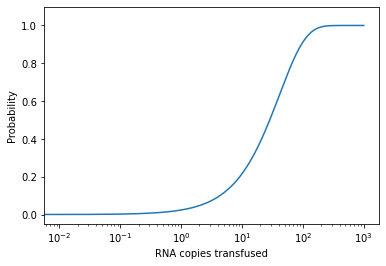

In [20]:
%matplotlib inline
x = np.arange(0, 1000, 0.01)
y = []
for copies in x:
    p = prob_infectious_copies(copies, k = k)
    y.append(p)
plt.plot(x, y)
plt.ylim(top=1.1)
plt.xscale("log")
plt.xlabel('RNA copies transfused')
plt.ylabel('Probability')

Text(0, 0.5, 'Probability')

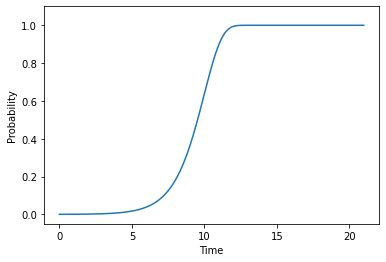

In [21]:
%matplotlib inline
x = np.arange(0, 21, 0.01)
y = []
for t in x:
    p = prob_infectious(t, 
                        C0, 
                        doubling_time, 
                        volume_transfused, 
                        k = k)
    y.append(p)
plt.plot(x, y)
plt.ylim(top=1.1)
plt.xlabel('Time')
plt.ylabel('Probability')

### Probability of non-detection

Text(0, 0.5, 'Probability')

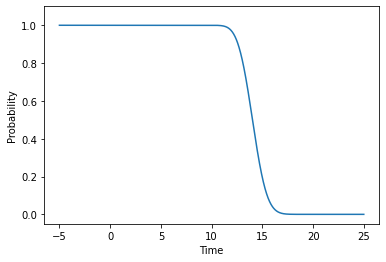

In [22]:
%matplotlib inline
x = np.arange(-5, 25, 0.01)
y = []
for t in x:
    p = prob_nondetection(t, 
                          copies_per_virion, 
                          C0, 
                          doubling_time, 
                          pool_size, 
                          lod50, 
                          lod95_lod50_ratio, 
                          retests)
    y.append(p)
plt.plot(x, y)
plt.ylim(top=1.1)
plt.xlabel('Time')
plt.ylabel('Probability')

### Probability of infection and non-detection

Text(0, 0.5, 'Probability')

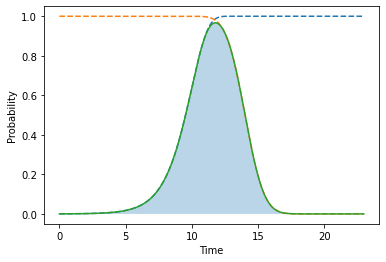

In [23]:
%matplotlib inline
x = np.arange(0, 23, 0.01)
y = []
inf = []
nd = []
for t in x:
    i = prob_infectious(t, 
                        C0, 
                        doubling_time, 
                        volume_transfused, 
                        k = k)
    inf.append(i)
    n = prob_nondetection(t, 
                          copies_per_virion, 
                          C0, 
                          doubling_time, 
                          pool_size, 
                          lod50, 
                          lod95_lod50_ratio, 
                          retests)
    nd.append(n)
    p = prob_infectious_nondetection(t, 
                                     copies_per_virion, 
                                     C0, 
                                     doubling_time, 
                                     volume_transfused, 
                                     k, 
                                     pool_size, 
                                     lod50, 
                                     lod95_lod50_ratio, 
                                     retests)
    y.append(p)
plt.plot(x, inf, '--')
plt.plot(x, nd, '--')
plt.plot(x, y)
plt.fill_between(x, 0, y, alpha = 0.3)
plt.ylim(top=1.05)
plt.xlabel('Time')
plt.ylabel('Probability')

### Probability of infection and non-detection (infectiousness worst case)

Text(0, 0.5, 'Probability')

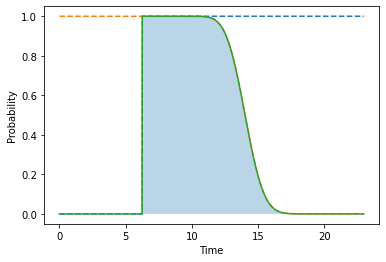

In [24]:
%matplotlib inline
x = np.arange(0, 23, 0.01)
y = []
inf = []
nd = []
for t in x:
    i = prob_infectious_wc(t, 
                        C0, 
                        doubling_time, 
                        volume_transfused)
    inf.append(i)
    n = prob_nondetection(t, 
                          copies_per_virion, 
                          C0, 
                          doubling_time, 
                          pool_size, 
                          lod50, 
                          lod95_lod50_ratio, 
                          retests)
    nd.append(n)
    p = prob_infectious_nondetection_wc(t, 
                                     copies_per_virion, 
                                     C0, 
                                     doubling_time, 
                                     volume_transfused, 
                                     pool_size, 
                                     lod50, 
                                     lod95_lod50_ratio, 
                                     retests)
    y.append(p)
plt.plot(x, inf, '--')
plt.plot(x, nd, '--')
plt.plot(x, y)
plt.fill_between(x, 0, y, alpha = 0.3)
plt.ylim(top=1.05)
plt.xlabel('Time')
plt.ylabel('Probability')

### Probability of infection and non-detection (ID-NAT)

Text(0, 0.5, 'Probability')

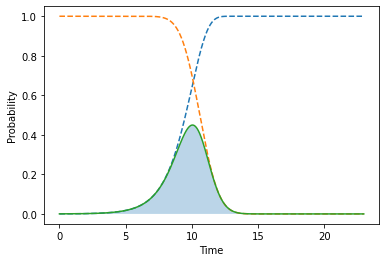

In [25]:
%matplotlib inline
x = np.arange(0, 23, 0.01)
y = []
inf = []
nd = []
for t in x:
    i = prob_infectious(t, 
                        C0, 
                        doubling_time, 
                        volume_transfused, 
                        k = k)
    inf.append(i)
    n = prob_nondetection(t, 
                          copies_per_virion, 
                          C0, 
                          doubling_time, 
                          pool_size_idnat, 
                          lod50, 
                          lod95_lod50_ratio, 
                          retests_idnat)
    nd.append(n)
    p = prob_infectious_nondetection(t, 
                                     copies_per_virion, 
                                     C0, 
                                     doubling_time, 
                                     volume_transfused, 
                                     k, 
                                     pool_size_idnat, 
                                     lod50, 
                                     lod95_lod50_ratio, 
                                     retests_idnat)
    y.append(p)
plt.plot(x, inf, '--')
plt.plot(x, nd, '--')
plt.plot(x, y)
plt.fill_between(x, 0, y, alpha = 0.3)
plt.ylim(top=1.05)
plt.xlabel('Time')
plt.ylabel('Probability')